In [1]:
import pandas as pd 
from ms2rescore import plotting
from immuno_ms2rescore_tools import file_utilities
from ms2rescore.percolator import PercolatorIn
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from functools import reduce
from collections import defaultdict

# Loading rescore data en plotting spectrum identification count & rate

In [2]:
ce_path = "/public/compomics/arthur/CNRS/ce_eval/msms_all/"

plotting.RescoreRecord.empty_rerecs()

pin = plotting.PIN(ce_path+"msms_searchengine_ms2pip_rt_features.pin", sample_name="CE", score_metric="RawScore")
searchengine = plotting.POUT(ce_path+"msms_searchengine_features.pout",ce_path+"msms_searchengine_features.pout_dec", rescoring_features="Search engine", sample_name="CE")
ms2rescore = plotting.POUT(ce_path+"msms_searchengine_ms2pip_rt_features.pout",ce_path+"msms_searchengine_ms2pip_rt_features.pout_dec", rescoring_features="MS²Rescore", sample_name="CE")


In [3]:
plotting.RescoreRecord._count_identifications([0.001, 0.01])
plotting.RescoreRecord._separate_unique_peptides(FDR_threshold=[0.001, 0.01])
plotting.RescoreRecord.calculate_loss_gain_df(FDR_threshold=[0.001,0.01],reference="Before rescoring")

In [4]:

mgf_files = file_utilities.MascotGenericFormat("/public/compomics/arthur/CNRS/ce_eval/mgf")
spectra_count = mgf_files.count_spectra()
spectra_count.set_index("raw file",inplace=True)

total_spectra = spectra_count.loc["total"]["spectra"]
print(total_spectra)
plotting.RescoreRecord.count_df["count"] = (plotting.RescoreRecord.count_df["count"]/total_spectra) * 100

100%|██████████| 15/15 [00:19<00:00,  1.28s/it]

419567


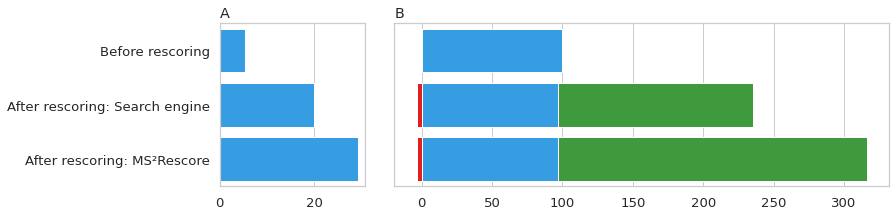

In [5]:
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2)
fig = plt.Figure(figsize=(12,3))

ax1 = plt.subplot2grid((1,4),(0,0), colspan=1, fig=fig)
sns.barplot(
    x="count",
    y="rescoring",
    data=plotting.RescoreRecord.count_df[plotting.RescoreRecord.count_df["FDR"]== 0.01],
    palette=sns.color_palette(["#1AA3FF","#1AA3FF","#1AA3FF","#B3E1FF"]),
    ax=ax1
)
ax1.set_ylabel("")
ax1.set_xlabel("")
ax1.set_title("A",loc="left")
ax2 = plt.subplot2grid((1,4),(0,1),colspan=3, fig=fig)
sns.barplot(
    y="feature",
    x="gain",
    data=plotting.RescoreRecord.loss_gain_df[plotting.RescoreRecord.loss_gain_df["FDR"]== 0.01],
    palette=sns.color_palette(["#2FA92D","#2FA92D","#2FA92D","#B3EBB2"]),
    ax=ax2,
)
sns.barplot(
    y="feature",
    x="shared",
    data=plotting.RescoreRecord.loss_gain_df[plotting.RescoreRecord.loss_gain_df["FDR"]== 0.01],
    palette=sns.color_palette(["#1AA3FF","#1AA3FF","#1AA3FF","#B3E1FF"]),
    ax=ax2,
)
sns.barplot(
    y="feature",
    x="loss",
    data=plotting.RescoreRecord.loss_gain_df[plotting.RescoreRecord.loss_gain_df["FDR"]== 0.01],
    palette=sns.color_palette(["#FF0000","#FF0000","#FF0000","#FFABAB"]),
    ax=ax2,
)
ax2.set_ylabel("")
ax2.set_xlabel("")
ax2.set_yticklabels([])
ax2.set_title("B",loc="left")

fig

# Collision energy results

In [6]:
def map_psmid_ce_value(psmids: pd.Series, mapper: dict):
    if "." in psmids.iloc[0]:
        ce_values = psmids.str.split(".", 1, expand=True)[0].map(mapper)
    else:
        ce_values = psmids.map(mapper)
    return ce_values

In [8]:
summary_df = pd.read_table("/public/compomics/arthur/CNRS/ce_eval/txt/summary.txt")
summary_df["CE"] = summary_df.Experiment.str.extract(r"CE (\d*) rep", expand=True)

In [9]:
ce_raw_map = pd.Series(summary_df.CE.values,index=summary_df["Raw file"]).to_dict()
ce_raw_map.pop("Total")

nan

In [10]:
ce_spectra_count = defaultdict(int)
for rawfile in ce_raw_map.keys():
    try:
        ce_spectra_count[ce_raw_map[rawfile]] += spectra_count.loc[rawfile]["spectra"]
    except KeyError:
        continue

In [11]:
rescoring_methods = ["no rescoring", "searchengine", "ms2rescore"]
ce_counts = []
for i, df in enumerate([pin.df, searchengine.df, ms2rescore.df]):
    rescoring_df = df.copy()
    rescoring_df["CE"] = map_psmid_ce_value(rescoring_df.PSMId, ce_raw_map)
    tmp = rescoring_df[(rescoring_df["q"] < 0.01) & (rescoring_df["is decoy"] == False)].groupby("CE").agg({"peptide":"count", "PSMId": list}).reset_index().rename({"peptide": f"psm count {rescoring_methods[i]}","PSMId": f"PSMId_{rescoring_methods[i]}"}, axis=1)
    ce_counts.append(tmp)

ce_count_df = reduce(lambda left,right:pd.merge(left, right, on=["CE"], how="outer"), ce_counts)
ce_count_df = ce_count_df[["CE", "psm count no rescoring", "psm count searchengine", "psm count ms2rescore", "PSMId_no rescoring", "PSMId_searchengine", "PSMId_ms2rescore"]]

In [12]:
ms2rescore_loss_gain = []
for i,row in ce_count_df.iterrows():
    tmp = {}
    tmp["CE"] = row.CE
    num_ids = len(set(row["PSMId_searchengine"]))
    tmp["shared"] = (len(set(row["PSMId_searchengine"]).intersection(set(row.PSMId_ms2rescore)))/num_ids) * 100
    tmp["gain"] = (len(set(row.PSMId_ms2rescore) - set(row["PSMId_searchengine"]))/num_ids) * 100
    tmp["loss"] = (len(set(row["PSMId_searchengine"]) - set(row.PSMId_ms2rescore))/num_ids) * 100
    ms2rescore_loss_gain.append(tmp)
ms2rescore_loss_gain = pd.DataFrame(ms2rescore_loss_gain)

In [13]:
ms2rescore_loss_gain["loss"] =ms2rescore_loss_gain["loss"] * -1
ms2rescore_loss_gain["gain"] =ms2rescore_loss_gain["gain"] + 100

In [14]:
ce_count_df.sort_values("psm count searchengine", ascending=False, inplace=True)
ms2rescore_loss_gain = ms2rescore_loss_gain.reindex(ce_count_df["CE"].index)

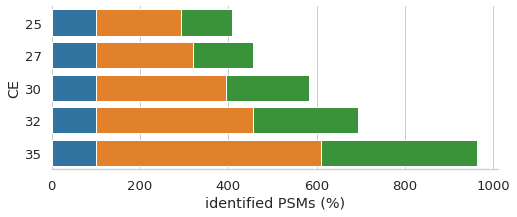

In [15]:
sns.set_style("whitegrid")
fig = plt.Figure(figsize=(8,3))
sns.set_color_codes("deep")

ax1 = fig.add_subplot(111)

ce_relative_count = ce_count_df.copy()
ce_relative_count.iloc[:,1:4] = ce_relative_count.iloc[:,1:4].div(ce_count_df["psm count no rescoring"].values, axis=0)
ce_relative_count.iloc[:,1:4] = ce_relative_count.iloc[:,1:4] * 100

sns.barplot(x="psm count ms2rescore", y="CE", label="ms2rescore", data=ce_relative_count, color="#2ca02c", ax=ax1)
sns.barplot(x="psm count searchengine", y="CE", label="searchengine", data=ce_relative_count, color="#ff7f0e", ax=ax1)
sns.barplot(x="psm count no rescoring", y="CE", label="no rescoring", data=ce_relative_count, color="#1f77b4", ax=ax1)

ax1.set_xlabel("identified PSMs (%)")
sns.despine(left=True, right=True, top=True, ax=ax1)
fig


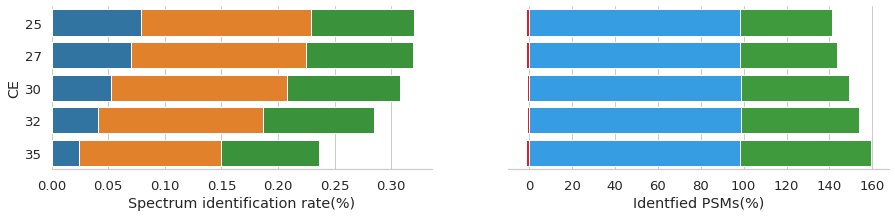

In [16]:
sns.set_style("whitegrid")
fig = plt.Figure(figsize=(15,3))
sns.set_color_codes("deep")

ax1 = fig.add_subplot(121)

ce_id_rate = ce_count_df.copy()
ce_id_rate.iloc[:,1:4] = ce_id_rate.iloc[:,1:4].div(pd.Series(ce_spectra_count).reindex(ce_id_rate["CE"]).values, axis=0)

sns.barplot(x="psm count ms2rescore", y="CE", label="ms2rescore", data=ce_id_rate, color="#2ca02c", ax=ax1)
sns.barplot(x="psm count searchengine", y="CE", label="searchengine", data=ce_id_rate, color="#ff7f0e", ax=ax1)
sns.barplot(x="psm count no rescoring", y="CE", label="no rescoring", data=ce_id_rate, color="#1f77b4", ax=ax1)

ax1.set_xlabel("Spectrum identification rate(%)")
sns.despine(left=True, right=True, top=True, ax=ax1)

ax2 = fig.add_subplot(122)

sns.barplot(
    y="CE",
    x="gain",
    data=ms2rescore_loss_gain,
    palette=sns.color_palette(["#2FA92D"]),
    ax=ax2,
)
sns.barplot(
    y="CE",
    x="shared",
    data=ms2rescore_loss_gain,
    palette=sns.color_palette(["#1AA3FF"]),
    ax=ax2,
)
sns.barplot(
    y="CE",
    x="loss",
    data=ms2rescore_loss_gain,
    palette=sns.color_palette(["#FF0000"]),
    ax=ax2,
)
ax2.set_xlabel("Identfied PSMs(%)")
ax2.set_ylabel("")
ax2.set(yticklabels=[])
sns.despine(left=True, right=True, top=True, ax=ax2)

fig



# Separate rescoring

In [19]:
ce_path = "/public/compomics/arthur/CNRS/ce_eval/msms_ce/"
plotting.RescoreRecord.empty_rerecs()
pins = []
searchengines = []
ms2rescores = []
for ce_value in ["25", "27", "30", "32" ,"35"]:
    pin = plotting.PIN(ce_path+f"msms{ce_value}_searchengine_ms2pip_rt_features.pin", sample_name=f"CE_{ce_value}", score_metric="RawScore")
    pins.append(pin.df)
    searchengine = plotting.POUT(ce_path+f"msms{ce_value}_searchengine_features.pout",ce_path+f"msms{ce_value}_searchengine_features.pout_dec", rescoring_features="Search engine", sample_name=f"CE_{ce_value}")
    searchengines.append(searchengine.df)
    ms2rescore = plotting.POUT(ce_path+f"msms{ce_value}_searchengine_ms2pip_rt_features.pout",ce_path+f"msms{ce_value}_searchengine_ms2pip_rt_features.pout_dec", rescoring_features="MS²Rescore", sample_name=f"CE_{ce_value}")
    ms2rescores.append(ms2rescore.df)

In [20]:
ce_path = "/public/compomics/arthur/CNRS/ce_eval/msms_all/"

plotting.RescoreRecord.empty_rerecs()

pin = plotting.PIN(ce_path+"msms_searchengine_ms2pip_rt_features.pin", sample_name="CE", score_metric="RawScore")
searchengine = plotting.POUT(ce_path+"msms_searchengine_features.pout",ce_path+"msms_searchengine_features.pout_dec", rescoring_features="Search engine", sample_name="CE")
ms2rescore = plotting.POUT(ce_path+"msms_searchengine_ms2pip_rt_features.pout",ce_path+"msms_searchengine_ms2pip_rt_features.pout_dec", rescoring_features="MS²Rescore", sample_name="CE")

In [21]:
pin.df = pd.concat(pins).reset_index(drop=True)
searchengine.df = pd.concat(searchengines).reset_index(drop=True)
ms2rescore.df = pd.concat(ms2rescores).reset_index(drop=True)

In [22]:
plotting.RescoreRecord._count_identifications([0.001, 0.01])
plotting.RescoreRecord._separate_unique_peptides(FDR_threshold=[0.001, 0.01])
plotting.RescoreRecord.calculate_loss_gain_df(FDR_threshold=[0.001,0.01],reference="Before rescoring")

# Collision energy results

In [23]:
def map_psmid_ce_value(psmids: pd.Series, mapper: dict):
    if "." in psmids.iloc[0]:
        ce_values = psmids.str.split(".", 1, expand=True)[0].map(mapper)
    else:
        ce_values = psmids.map(mapper)
    return ce_values

In [24]:
summary_df = pd.read_table("/public/compomics/arthur/CNRS/ce_eval/txt/summary.txt")
summary_df["CE"] = summary_df.Experiment.str.extract(r"CE (\d*) rep", expand=True)

In [25]:
ce_raw_map = pd.Series(summary_df.CE.values,index=summary_df["Raw file"]).to_dict()
ce_raw_map.pop("Total")

nan

In [26]:
ce_spectra_count = defaultdict(int)
for rawfile in ce_raw_map.keys():
    try:
        ce_spectra_count[ce_raw_map[rawfile]] += spectra_count.loc[rawfile]["spectra"]
    except KeyError:
        continue

In [27]:
rescoring_methods = ["no rescoring", "searchengine", "ms2rescore"]
ce_counts = []
for i, df in enumerate([pin.df, searchengine.df, ms2rescore.df]):
    rescoring_df = df.copy()
    rescoring_df["CE"] = map_psmid_ce_value(rescoring_df.PSMId, ce_raw_map)
    tmp = rescoring_df[(rescoring_df["q"] < 0.01) & (rescoring_df["is decoy"] == False)].groupby("CE").agg({"peptide":"count", "PSMId": list}).reset_index().rename({"peptide": f"psm count {rescoring_methods[i]}","PSMId": f"PSMId_{rescoring_methods[i]}"}, axis=1)
    ce_counts.append(tmp)

ce_count_df = reduce(lambda left,right:pd.merge(left, right, on=["CE"], how="outer"), ce_counts)
ce_count_df = ce_count_df[["CE", "psm count no rescoring", "psm count searchengine", "psm count ms2rescore", "PSMId_no rescoring", "PSMId_searchengine", "PSMId_ms2rescore"]]

In [28]:
ms2rescore_loss_gain = []
for i,row in ce_count_df.iterrows():
    tmp = {}
    tmp["CE"] = row.CE
    num_ids = len(set(row["PSMId_searchengine"]))
    tmp["shared"] = (len(set(row["PSMId_searchengine"]).intersection(set(row.PSMId_ms2rescore)))/num_ids) * 100
    tmp["gain"] = (len(set(row.PSMId_ms2rescore) - set(row["PSMId_searchengine"]))/num_ids) * 100
    tmp["loss"] = (len(set(row["PSMId_searchengine"]) - set(row.PSMId_ms2rescore))/num_ids) * 100
    ms2rescore_loss_gain.append(tmp)
ms2rescore_loss_gain = pd.DataFrame(ms2rescore_loss_gain)

In [29]:
ms2rescore_loss_gain["loss"] =ms2rescore_loss_gain["loss"] * -1
ms2rescore_loss_gain["gain"] =ms2rescore_loss_gain["gain"] + 100

In [30]:
ce_count_df.sort_values("psm count searchengine", ascending=False, inplace=True)
ms2rescore_loss_gain = ms2rescore_loss_gain.reindex(ce_count_df["CE"].index)

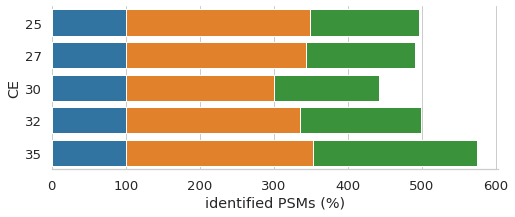

In [31]:
sns.set_style("whitegrid")
fig = plt.Figure(figsize=(8,3))
sns.set_color_codes("deep")

ax1 = fig.add_subplot(111)

ce_relative_count = ce_count_df.copy()
ce_relative_count.iloc[:,1:4] = ce_relative_count.iloc[:,1:4].div(ce_count_df["psm count no rescoring"].values, axis=0)
ce_relative_count.iloc[:,1:4] = ce_relative_count.iloc[:,1:4] * 100

sns.barplot(x="psm count ms2rescore", y="CE", label="ms2rescore", data=ce_relative_count, color="#2ca02c", ax=ax1)
sns.barplot(x="psm count searchengine", y="CE", label="searchengine", data=ce_relative_count, color="#ff7f0e", ax=ax1)
sns.barplot(x="psm count no rescoring", y="CE", label="no rescoring", data=ce_relative_count, color="#1f77b4", ax=ax1)

ax1.set_xlabel("identified PSMs (%)")
sns.despine(left=True, right=True, top=True, ax=ax1)
fig


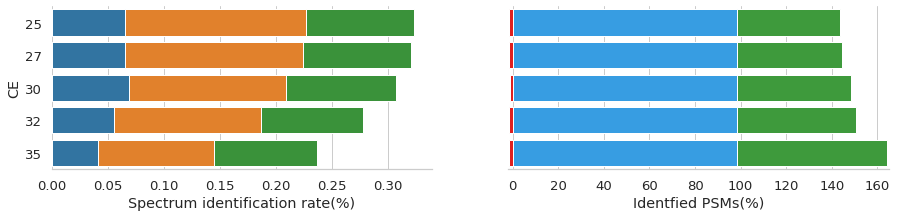

In [35]:
sns.set_style("whitegrid")
fig = plt.Figure(figsize=(15,3))
sns.set_color_codes("deep")

ax1 = fig.add_subplot(121)

ce_id_rate = ce_count_df.copy()
ce_id_rate.iloc[:,1:4] = ce_id_rate.iloc[:,1:4].div(pd.Series(ce_spectra_count).reindex(ce_id_rate["CE"]).values, axis=0)

sns.barplot(x="psm count ms2rescore", y="CE", label="ms2rescore", data=ce_id_rate, color="#2ca02c", ax=ax1)
sns.barplot(x="psm count searchengine", y="CE", label="searchengine", data=ce_id_rate, color="#ff7f0e", ax=ax1)
sns.barplot(x="psm count no rescoring", y="CE", label="no rescoring", data=ce_id_rate, color="#1f77b4", ax=ax1)

ax1.set_xlabel("Spectrum identification rate(%)")
sns.despine(left=True, right=True, top=True, ax=ax1)

ax2 = fig.add_subplot(122)

sns.barplot(
    y="CE",
    x="gain",
    data=ms2rescore_loss_gain,
    palette=sns.color_palette(["#2FA92D"]),
    ax=ax2,
)
sns.barplot(
    y="CE",
    x="shared",
    data=ms2rescore_loss_gain,
    palette=sns.color_palette(["#1AA3FF"]),
    ax=ax2,
)
sns.barplot(
    y="CE",
    x="loss",
    data=ms2rescore_loss_gain,
    palette=sns.color_palette(["#FF0000"]),
    ax=ax2,
)
ax2.set_xlabel("Identfied PSMs(%)")
ax2.set_xlim(-2,165)
ax2.set_ylabel("")
ax2.set(yticklabels=[])
sns.despine(left=True, right=True, top=True, ax=ax2)

fig



# Weights analysis

In [55]:
def calculate_feature_weights(weights_file, ce):
    feature_weights = {}
    feature_weights["CE"] = ce

    weights = pd.read_table(weights_file, sep="\t")
    weights.drop([1,2,4,5,7], axis=0, inplace=True)
    weights.drop("m0", axis=1, inplace=True)
    weights = weights.astype(float)
    weights.loc["mean"] = weights.mean()

    total_weight = sum(weights.iloc[3, :71].abs()) + sum(weights.iloc[3, 71:77].abs()) + sum(weights.iloc[3, 77:].abs())
    feature_weights["MS²PIP"] = (sum(weights.iloc[3, :71].abs())  /total_weight) * 100
    feature_weights["DeepLC"] = (sum(weights.iloc[3, 71:77].abs()) /total_weight) * 100
    feature_weights["Search engine"] = (sum(weights.iloc[3, 77:].abs()) /total_weight) * 100
    

    return feature_weights

In [56]:
weights_df = pd.DataFrame([calculate_feature_weights(f"/public/compomics/arthur/CNRS/ce_eval/msms_ce/msms{x}_searchengine_ms2pip_rt_features.weights", x) for x in ["25", "27", "30", "32" ,"35"]])
weights_df["Search engine"] = weights_df["Search engine"] + weights_df["MS²PIP"]
weights_df["DeepLC"] = weights_df["Search engine"] + weights_df["DeepLC"]

weights_df = weights_df.reindex(ce_count_df["CE"].index)

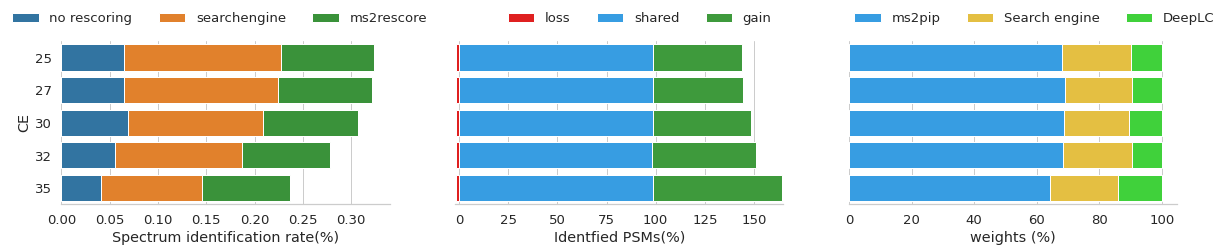

In [80]:
sns.set_style("whitegrid")
fig = plt.Figure(figsize=(20,3))
sns.set_color_codes("deep")
order = [2,1,0]

ax1 = fig.add_subplot(131)


sns.barplot(x="psm count ms2rescore", y="CE", label="ms2rescore", data=ce_id_rate, color="#2ca02c", ax=ax1)
sns.barplot(x="psm count searchengine", y="CE", label="searchengine", data=ce_id_rate, color="#ff7f0e", ax=ax1)
sns.barplot(x="psm count no rescoring", y="CE", label="no rescoring", data=ce_id_rate, color="#1f77b4", ax=ax1)
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(
    [handles[idx] for idx in order],
    [labels[idx] for idx in order],
    frameon=False, 
    ncol=3, 
    bbox_to_anchor=(1.15,1.25)
)
ax1.set_xlabel("Spectrum identification rate(%)")
sns.despine(left=True, right=True, top=True, ax=ax1)

ax2 = fig.add_subplot(132)

sns.barplot(
    y="CE",
    x="gain",
    data=ms2rescore_loss_gain,
    palette=sns.color_palette(["#2FA92D"]),
    ax=ax2,
    label="gain"
)
sns.barplot(
    y="CE",
    x="shared",
    data=ms2rescore_loss_gain,
    palette=sns.color_palette(["#1AA3FF"]),
    ax=ax2,
    label="shared"
)
sns.barplot(
    y="CE",
    x="loss",
    data=ms2rescore_loss_gain,
    palette=sns.color_palette(["#FF0000"]),
    ax=ax2,
    label="loss"
)
ax2.set_xlabel("Identfied PSMs(%)")
ax2.set_xlim(-2,165)
ax2.set_ylabel("")
ax2.set(yticklabels=[])
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(
    [handles[idx] for idx in order],
    [labels[idx] for idx in order],
    frameon=False, 
    ncol=3, 
    bbox_to_anchor=(1,1.25)
)
sns.despine(left=True, right=True, top=True, ax=ax2)

ax3 = fig.add_subplot(133)

sns.barplot(
    y="CE",
    x="DeepLC",
    data=weights_df,
    palette=sns.color_palette(["#28ea22"]),
    ax=ax3,
    label="DeepLC"
)
sns.barplot(
    y="CE",
    x="Search engine",
    data=weights_df,
    palette=sns.color_palette(["#FFCD27"]),
    ax=ax3,
    label="Search engine"
)
sns.barplot(
    y="CE",
    x="MS²PIP",
    data=weights_df,
    palette=sns.color_palette(["#1AA3FF"]),
    ax=ax3,
    label="ms2pip"
)
ax3.set_xlabel("weights (%)")
ax3.set_ylabel("")
ax3.set(yticklabels=[])
handles, labels = ax3.get_legend_handles_labels()
ax3.legend(
    [handles[idx] for idx in order],
    [labels[idx] for idx in order],
    frameon=False, 
    ncol=3, 
    bbox_to_anchor=(1.15,1.25)
)
sns.despine(left=True, right=True, top=True, ax=ax3)

fig
